# Skip-gram Word2Vec

## Some Theory 

### Word embedding

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an embedding lookup and the number of hidden units is the embedding dimension.

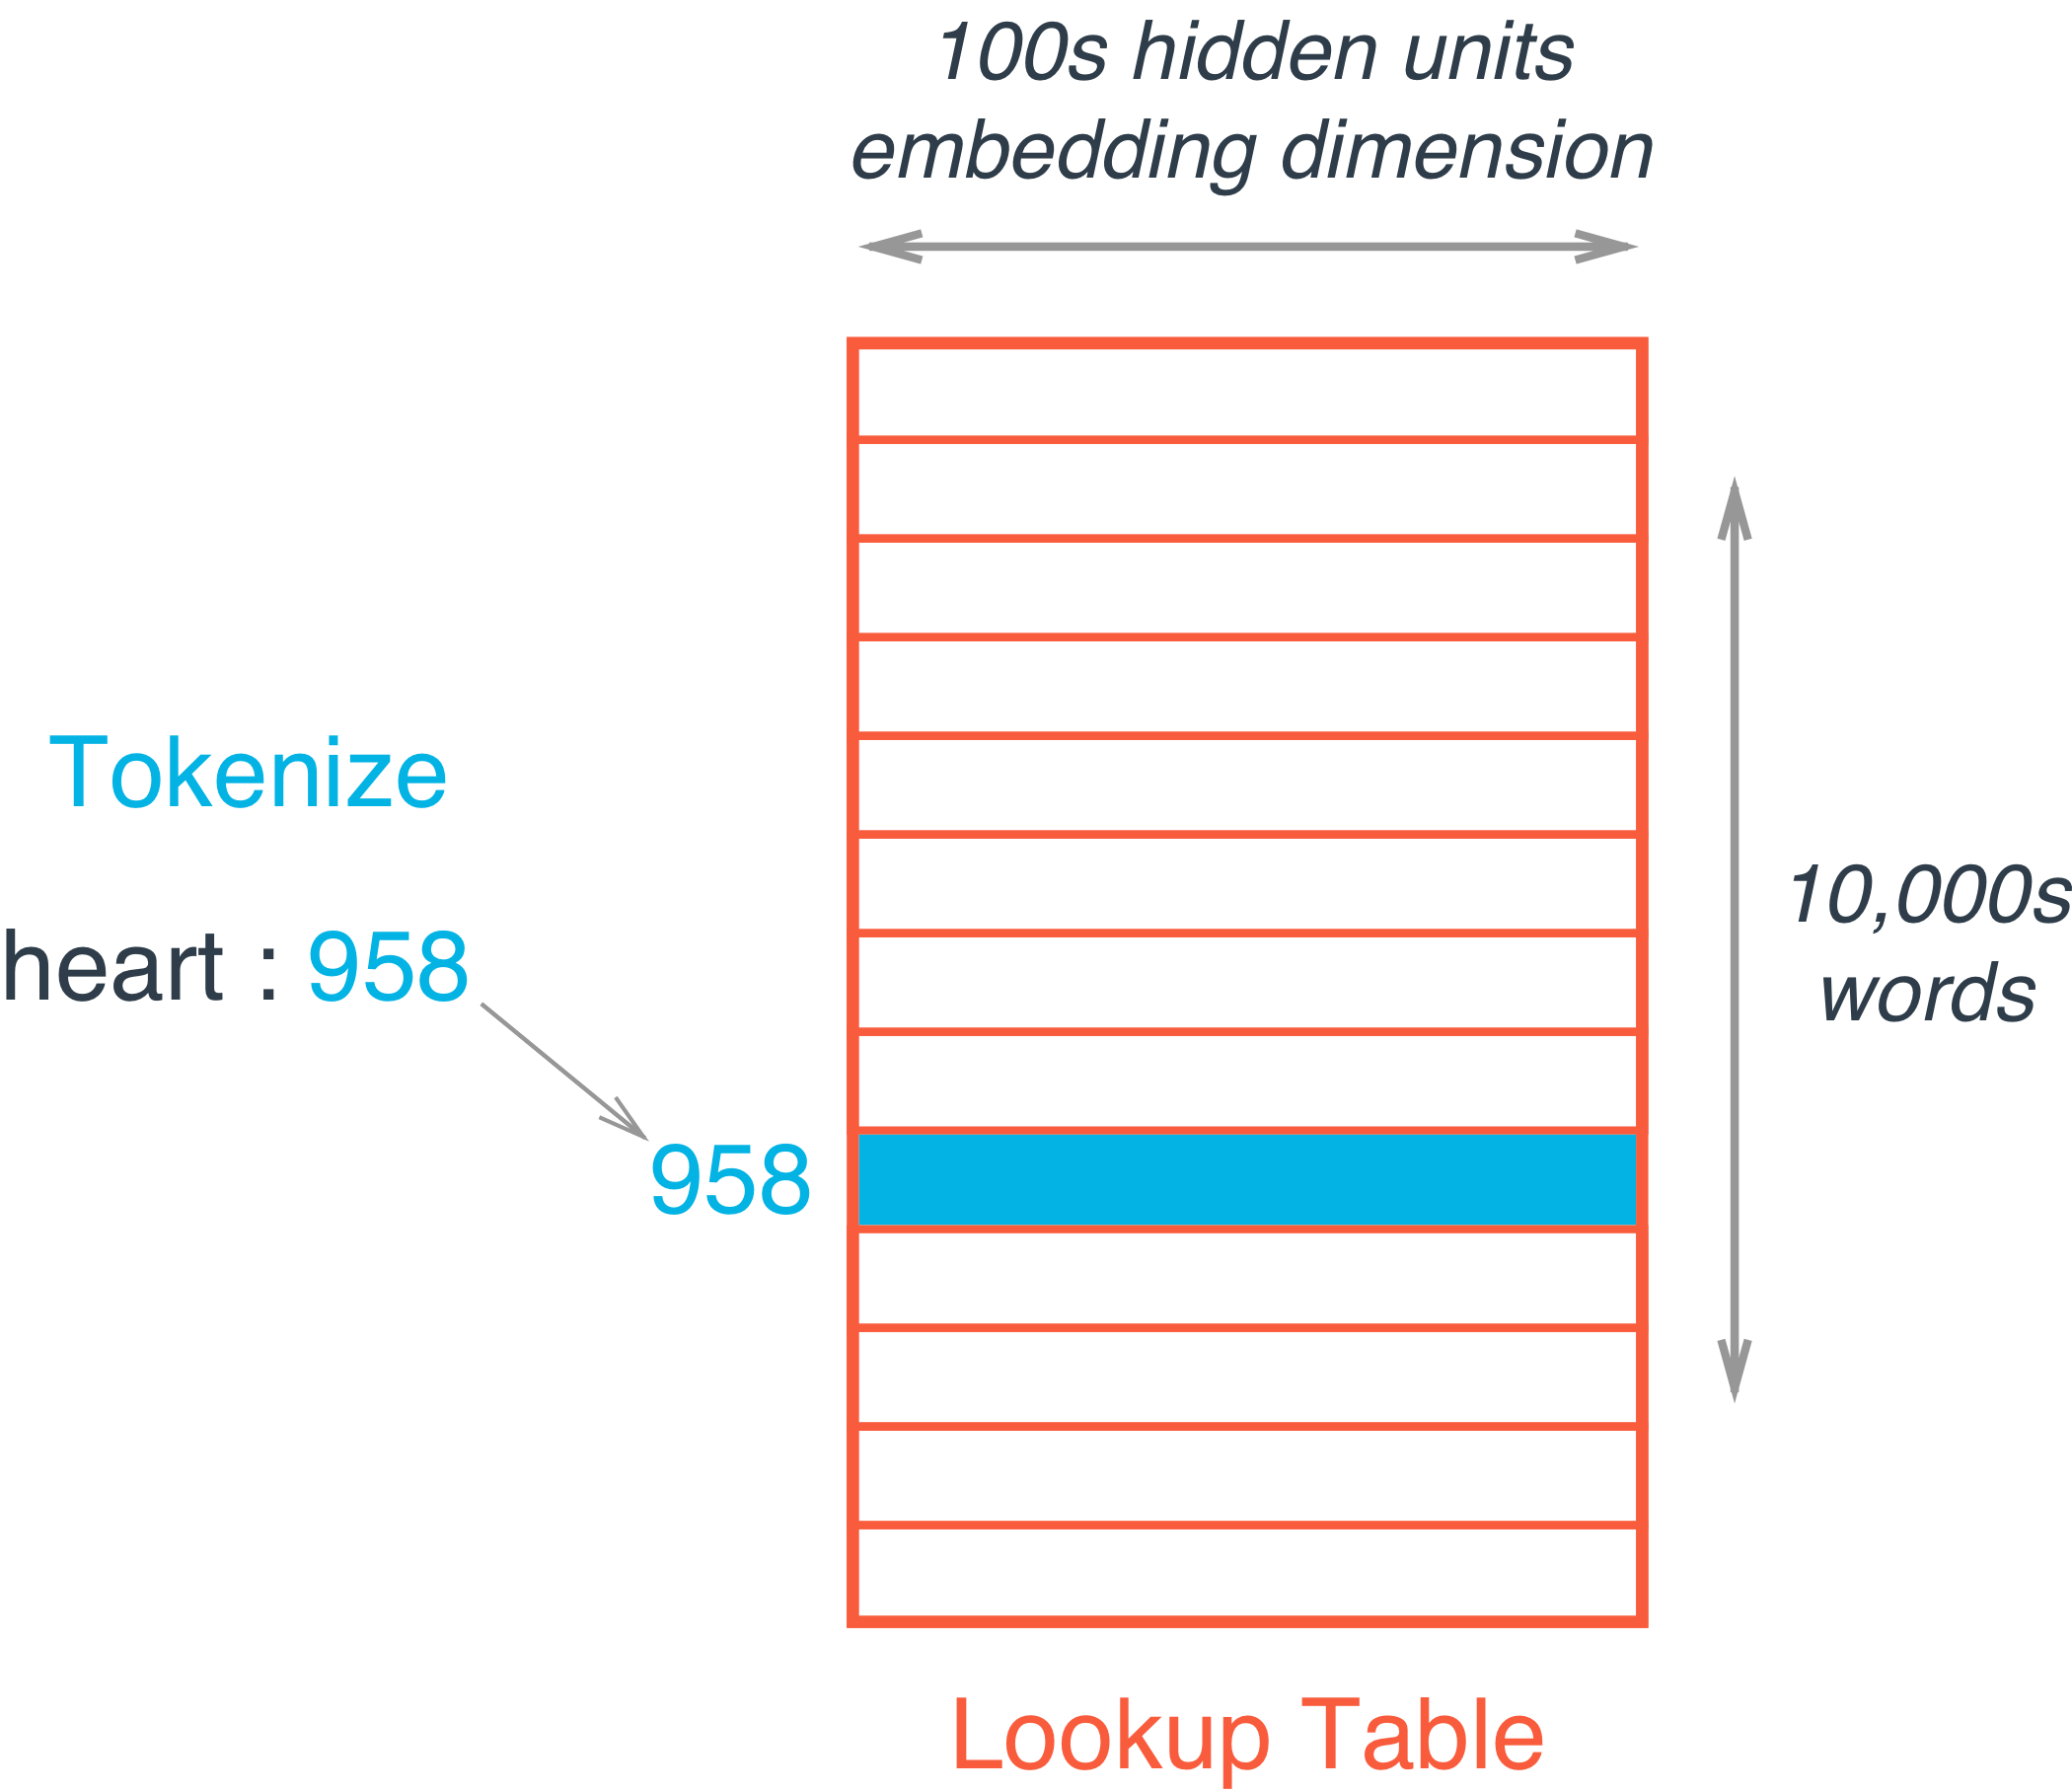

In [1]:
from IPython.display import Image

Image(filename='assets/tokenize_lookup.png', width='50%')

### Word2Vec: Skip Gram model

The Word2Vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words.

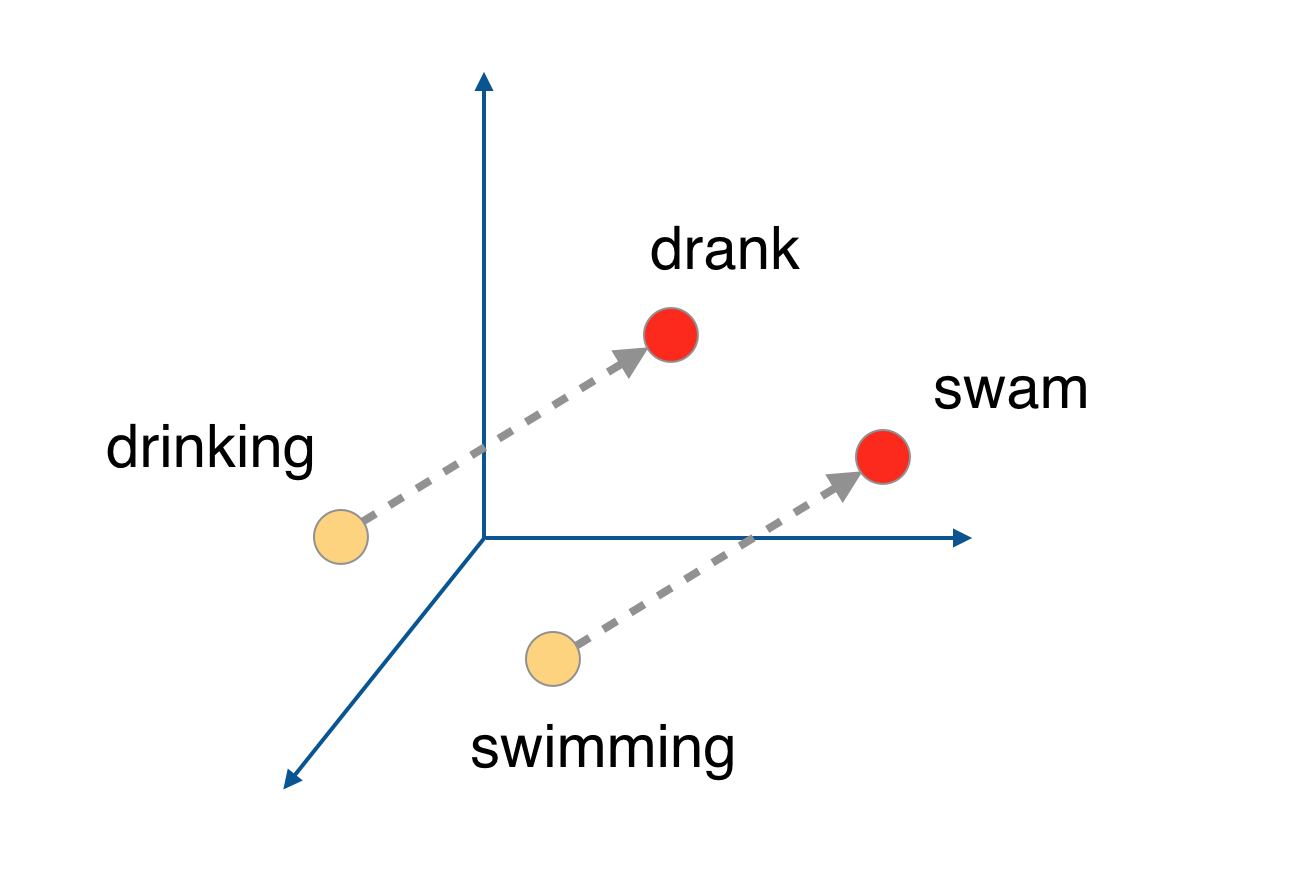

In [2]:
Image(filename='assets/vector_distance.png', width='40%')

SkipGram: we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts

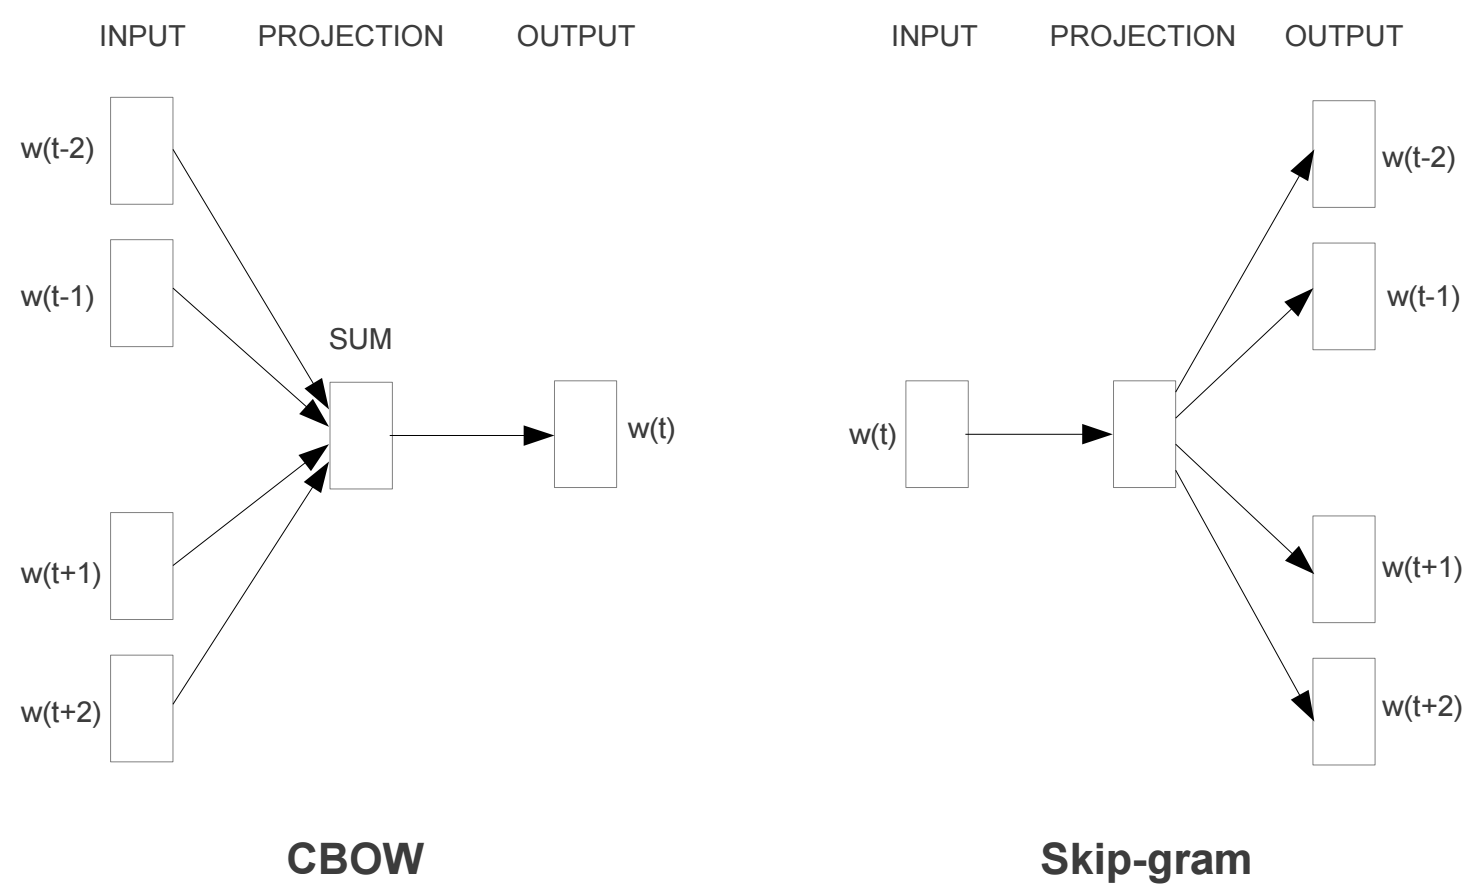

In [3]:
Image(filename="assets/word2vec_architectures.png", width='60%')

## Data

In [4]:
with open('data/text8') as f:
    text = f.read()
    
text[:100]

' anarchism originated as a term of abuse first used against early working class radicals including t'

## Pre-processing

Use two function from `utils.py`: pre processing and create_lookup_tables

In [5]:
import utils

words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [6]:
# some stats about the text
print('Total words:',len(words))
print('Uniques words:',len(set(words)))

Total words: 16680599
Uniques words: 63641


In [7]:
vocab2int, int2vocab = utils.create_lookup_tables(words)
int_words = [vocab2int[word] for word in words]
print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


## Subsamplig

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{1*10^6/16*10^6}} = 0.98735 $$

In [8]:
from collections import Counter
import numpy as np
import random

threshold = 1e-5
total_words = len(int_words)
word_counts = Counter(int_words)

prob = {int_word: 1-(threshold/(count/total_words))**0.5 for int_word, count in word_counts.items()}
train_words = [word for word in int_words if 1 - prob[word] > random.random()]

In [9]:
word_counts

Counter({5233: 303,
         3080: 572,
         11: 131815,
         5: 325873,
         194: 7219,
         1: 593677,
         3133: 563,
         45: 28810,
         58: 22737,
         155: 8432,
         127: 10172,
         741: 2271,
         476: 3412,
         10571: 116,
         133: 9633,
         0: 1061396,
         27349: 25,
         102: 11868,
         854: 2029,
         2: 416629,
         15067: 68,
         58112: 6,
         150: 8736,
         3580: 481,
         10: 183153,
         190: 7378,
         4: 372201,
         10712: 114,
         214: 6433,
         6: 316376,
         1324: 1352,
         104: 11803,
         454: 3502,
         19: 109510,
         2731: 653,
         362: 4165,
         3672: 466,
         708: 2374,
         371: 4067,
         26: 73334,
         40: 37866,
         36: 44358,
         53: 25383,
         539: 3043,
         97: 12445,
         1423: 1254,
         2757: 646,
         18: 111831,
         567: 2879,
         

In [10]:
303/total_words

1.8164815304294527e-05

In [11]:
word_counts[0]

1061396

In [12]:
1061396/16680599

0.06363056866243233

In [13]:
print('Total words in train_words:', len(train_words))
print('Uniques words in train_words:', len(set(train_words)))

Total words in train_words: 4628182
Uniques words in train_words: 63641


Reduce total words from 16,680,599 to 4,629,218.

## Batches

From Mikolov et al.:

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose  𝐶=5 , for each training word we will select randomly a number  𝑅  in range  [1:𝐶] , and then use  𝑅  words from history and  𝑅  words from the future of the current word as correct labels."

Say, we have an input and we're interested in the idx=2 token, `741`: 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

For `R=2`, `get_target` should return a list of four values:
```
[5233, 58, 10571, 27349]
```

In [14]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size + 1)
    
    return [words[i] for i in range(len(words)) if not (i > idx + R or i < idx - R or i == idx)]

In [15]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [16]:
# test the code
lista = [5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
idx = 5

get_target(lista, idx = idx)

[58, 741, 10571, 27349, 15067, 58112, 3580, 58]

In [17]:
# test the code
x, y = next(get_batches(lista, batch_size=4))

print('x\n', x)
print('y\n', y)
print(len(x))

x
 [5233, 5233, 5233, 58, 58, 58, 741, 741, 741, 10571, 10571, 10571]
y
 [58, 741, 10571, 5233, 741, 10571, 5233, 58, 10571, 5233, 58, 741]
12


## Skip Gram

* The input words are passed in as batches of input word tokens. 
* This will go into a hidden layer of linear units (our embedding layer). 
* Then, finally into a softmax output layer.

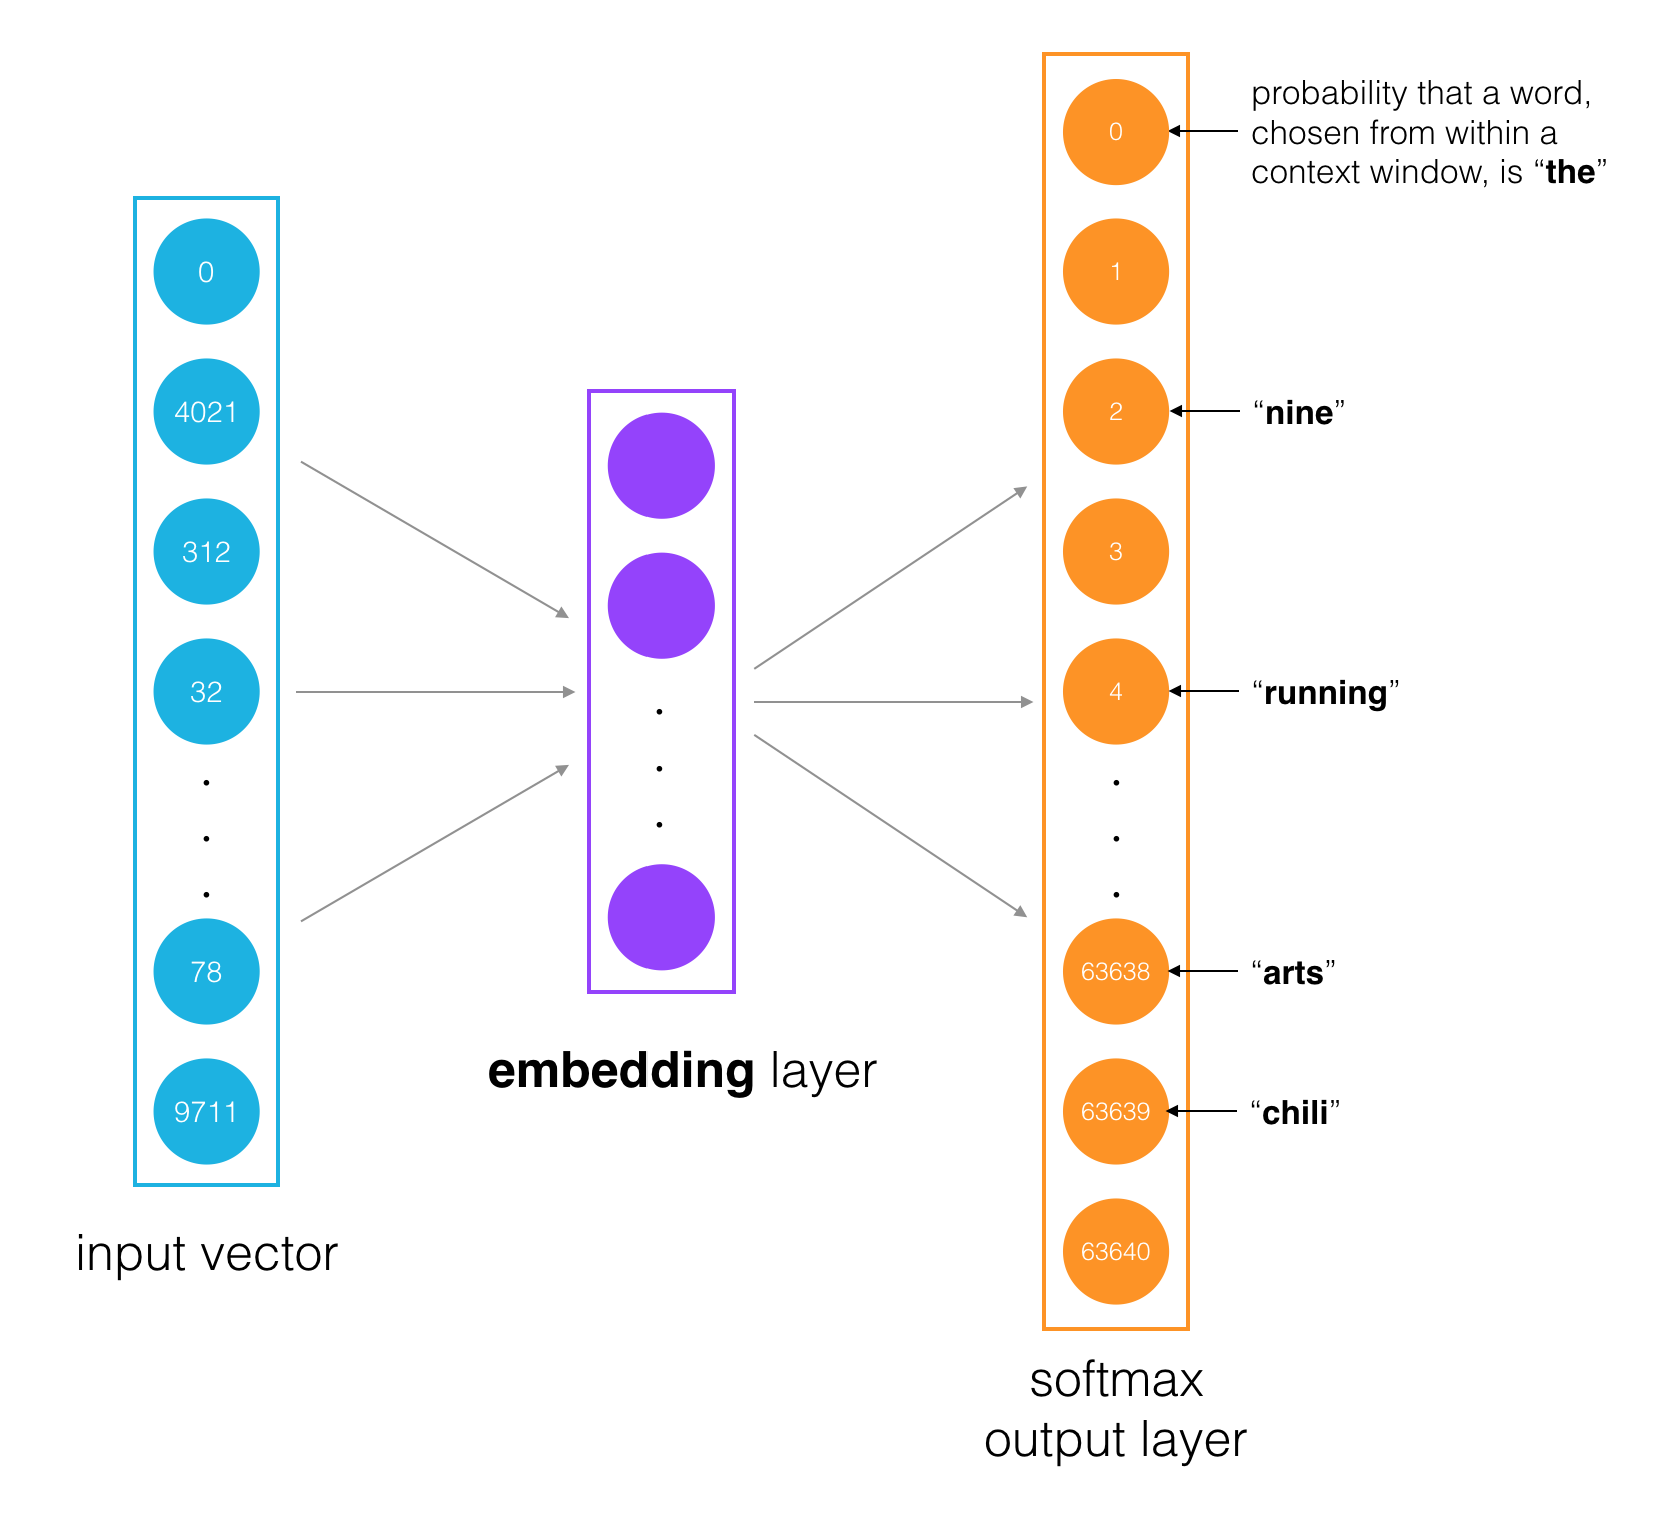

In [18]:
Image(filename="assets/skip_gram_arch.png", width='60%')

## Cosine similarity

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$

In [19]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    
    embedding_vector = embedding.weight
    
    magnitudes = embedding_vector.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick 'valid_size' words from our ranges (0, window) and (1000, 1000+window). lower id implies more frequent 
    valid_sample = np.array(random.sample(range(valid_window), valid_size//2))
    valid_sample = np.append(valid_sample, np.array(random.sample(range(1000, 1000 + valid_window), valid_size//2)))
    # numpy to tensor
    valid_sample = torch.LongTensor(valid_sample).to(device)
    
    # list of weights of the valid_sample
    valid_vector = embedding(valid_sample)
    similarities = torch.mm(valid_vector, embedding_vector.t())/magnitudes
    
    return valid_sample, similarities

## Negative Sampling

For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct example, but only a small number of incorrect, or noise, examples. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). 

There are two modifications we need to make. First, since we're not taking the softmax output over all the words, we're really only concerned with one output word at a time. Similar to how we use an embedding table to map the input word to the hidden layer, we can now use another embedding table to map the hidden layer to the output word. Now we have two embedding layers, one for input words and one for output words. Secondly, we use a modified loss function where we only care about the true example and a small subset of noise examples.

$$
- \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)}
$$

This is a little complicated so I'll go through it bit by bit. $u_{w_O}\hspace{0.001em}^\top$ is the embedding vector for our "output" target word (transposed, that's the $^\top$ symbol) and $v_{w_I}$ is the embedding vector for the "input" word. Then the first term 

$$\large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)}$$

says we take the log-sigmoid of the inner product of the output word vector and the input word vector. Now the second term, let's first look at 

$$\large \sum_i^N \mathbb{E}_{w_i \sim P_n(w)}$$ 

This means we're going to take a sum over words $w_i$ drawn from a noise distribution $w_i \sim P_n(w)$. The noise distribution is basically our vocabulary of words that aren't in the context of our input word. In effect, we can randomly sample words from our vocabulary to get these words. $P_n(w)$ is an arbitrary probability distribution though, which means we get to decide how to weight the words that we're sampling. This could be a uniform distribution, where we sample all words with equal probability. Or it could be according to the frequency that each word shows up in our text corpus, the unigram distribution $U(w)$. The authors found the best distribution to be $U(w)^{3/4}$, empirically. 

Finally, in 

$$\large \log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)},$$ 

we take the log-sigmoid of the negated inner product of a noise vector with the input vector. 

In [20]:
import torch
from torch import nn
import torch.optim as optim

In [21]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist = None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        self.in_embedding = nn.Embedding(n_vocab, n_embed)
        self.out_embedding = nn.Embedding(n_vocab, n_embed)
        
        # Initialize embedding tables with uniform distribution
        # I believe this helps with convergence
        self.in_embedding.weight.data.uniform_(-1, 1)
        self.out_embedding.weight.data.uniform_(-1, 1)
        
    def forward_input(self, input_words):
        input_vectors = self.in_embedding(input_words)
              
        return input_vectors
    
    def forward_output(self, output_words):
        output_vectors = self.out_embedding(output_words)
        
        return output_vectors
    
    def forward_noise(self, batch_size, n_samples):
        if self.noise_dist == None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
        
        # Sample words from our noise distribution
        noise_words = torch.multinomial(noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)
        
        device = 'cuda' if  model.out_embedding.weight.is_cuda else 'cpu'   
        noise_words = noise_words.to(device)
        
        noise_vectors = self.out_embedding(noise_words).view(batch_size, n_samples, self.n_embed)
        
        return noise_vectors

In [22]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):    
        batch_size, embed_size = input_vectors.shape
        
        # Input vectors should be a batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        
        # Output vectors should be a batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        
        # bmm = batch matrix multiplication
        # correct log-sigmoid loss
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        
        # incorrect log-sigmoid loss
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        # negate and sum correct and noisy log-sigmoid losses
        # return average batch loss
        return -(out_loss + noise_loss).mean()

## Training

In [23]:
# Get our noise distribution
freqs = {word: count/total_words for word, count in word_counts.items()}

word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

In [24]:
import matplotlib.pyplot as plt
plt.plot(noise_dist)
plt.show()

<Figure size 640x480 with 1 Axes>

In [25]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [26]:
embedding_dim = 300
model = SkipGramNeg(len(set(int_words)), embedding_dim, noise_dist=noise_dist).to(device)
model

SkipGramNeg(
  (in_embedding): Embedding(63641, 300)
  (out_embedding): Embedding(63641, 300)
)

In [27]:
criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [28]:
steps = 0
epochs = 5
print_every = 1500

for epoch in range(epochs):
    for inputs, targets in get_batches(train_words, batch_size = 512):
        steps += 1
        # inputs, targets
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, output, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], n_samples=5)
        
        optimizer.zero_grad()
        
        loss = criterion(input_vectors, output_vectors, noise_vectors)
        loss.backward()
        optimizer.step()
        
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(epoch+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            
            valid_samples, similarities = cosine_similarity(model.in_embedding, device=device)
            _, top_words_idx = similarities.topk(6)
            
            valid_samples, top_words_idx = valid_samples.to('cpu'), top_words_idx.to('cpu')
            top_words_idx = top_words_idx.tolist()
            for i in range(len(top_words_idx)):
                top_words = list(map(lambda x: int2vocab[x], top_words_idx[i]))
                print(top_words[0] + ' | ' + ', '.join(top_words[1:]))
            print('----------\n')
                

Epoch: 1/5
Loss:  6.644004821777344
first | voters, than, chance, francium, october
often | cholera, delivered, monkey, yahoo, theological
american | intersection, amounts, selected, dogs, constructed
d | the, four, of, a, hebrew
these | ryerson, management, mixed, communication, garden
and | the, one, a, twelve, about
not | collection, prospectors, determine, eyeless, retro
during | our, snares, common, was, targets
institute | audiences, truth, icbn, bicycle, strapped
units | nuclear, shortages, compaq, quebecois, leverage
resources | mancala, bulgarians, shock, analyse, domitius
question | extremism, pakistanis, brassicaceae, fulfilling, alternating
existence | troubled, lead, receptors, punctuated, palaces
versions | scan, registered, longest, adjustment, troops
police | streamline, mini, avocados, whiskey, microcomputers
taking | marat, petitioned, counterintuitive, beryllium, scheme
----------

Epoch: 1/5
Loss:  4.920698165893555
been | are, of, this, they, at
war | four, runner,

these | are, important, can, different, based
are | these, can, various, specific, there
from | and, in, the, with, of
as | and, is, a, of, into
th | century, nd, rd, one, st
notes | ed, dictionary, music, see, articles
grand | duke, prince, french, denmark, princess
alternative | based, useful, version, example, uses
quite | somewhat, required, way, often, there
magazine | homepage, magazines, mike, com, online
governor | appointed, president, minister, william, governors
centre | port, park, cities, largest, buildings
bible | testament, biblical, tanakh, hebrew, torah
----------

Epoch: 3/5
Loss:  2.3569252490997314
three | six, five, two, zero, four
of | in, and, the, by, with
it | that, to, is, be, from
people | ethnic, population, speaking, living, spoken
from | the, and, with, also, of
he | him, his, himself, friend, went
has | are, is, with, communities, and
used | is, use, or, also, using
applied | are, produce, varieties, used, properties
professional | players, league, compet

frac | equation, sqrt, infty, sum, mathbf
test | tests, testing, nuclear, determine, ban
defense | defensive, staff, defence, foreign, civilian
shown | different, few, like, shows, adapted
brother | son, mother, wife, father, his
universe | cosmic, cosmology, galaxy, bang, universes
----------

Epoch: 4/5
Loss:  2.4174578189849854
has | is, some, the, for, are
with | of, to, and, a, which
not | that, to, be, with, other
he | him, his, himself, she, father
have | are, to, can, other, their
during | the, at, in, ii, after
can | are, or, is, be, using
the | a, of, in, from, and
rise | highly, many, from, its, in
additional | are, normal, be, each, consists
nobel | prize, laureate, physicist, recipient, american
prince | heir, ii, emperor, king, princess
know | you, we, saying, answer, thing
http | www, htm, html, org, edu
pope | gregory, papal, xii, iv, bishop
behind | the, that, a, night, back
----------

Epoch: 5/5
Loss:  2.3779494762420654
no | not, according, that, they, a
it | that, 

## Visualizing the word vectors
​
Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together.

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.manifold import TSNE

In [30]:
embeddings = model.in_embedding.weight.to('cpu').data.numpy()

In [31]:
viz_words = 380
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

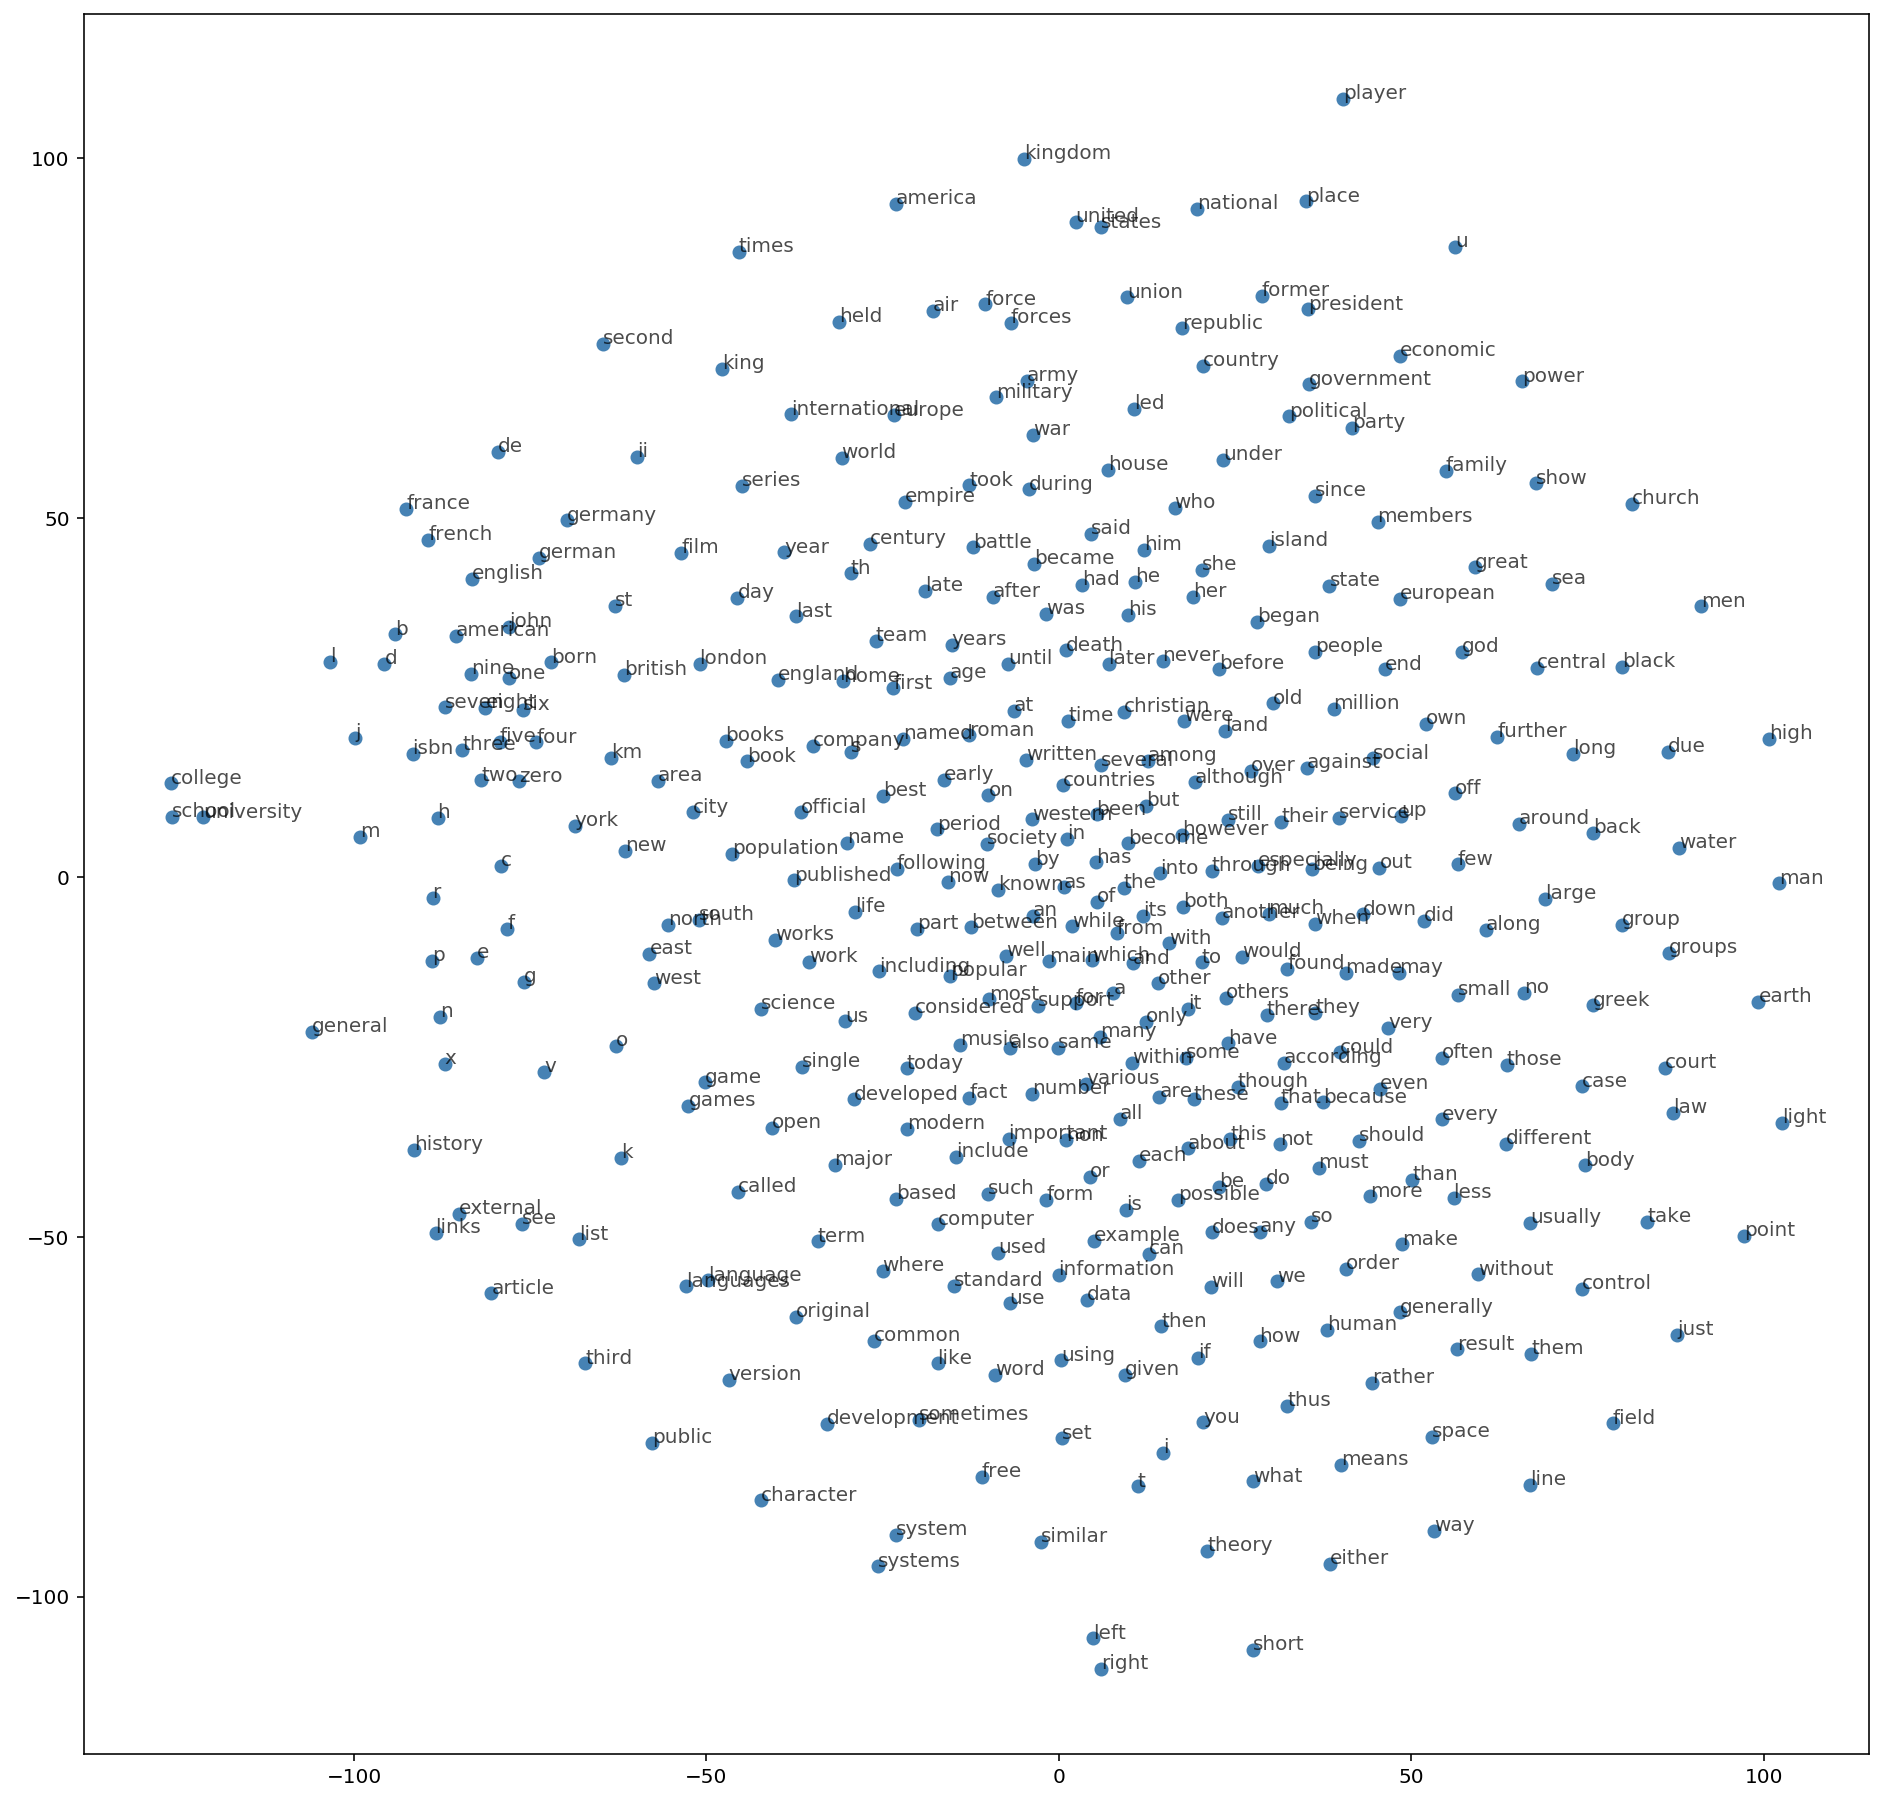

In [32]:
ig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int2vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)